In [1]:
import random
import torch
from torch.distributions import MultivariateNormal
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
import gensim
import gensim.downloader as glove_api
import os
import io
import time

from matplotlib import pyplot as pl
import seaborn as sns
import matplotlib.pylab as plt
import pickle

from ZorkGym.text_utils.text_parser import BagOfWords, Word2Vec, TextParser, tokenizer, BasicParser
from networks.cnn import TextCNN
from agents.OMP_DDPG import OMPDDPG

In [2]:
from __future__ import division, print_function
import sys
from scipy.linalg import norm
from math import sqrt
from sklearn.base import BaseEstimator
from sklearn.datasets.base import Bunch
from sklearn.metrics import roc_auc_score
from hashlib import sha1

In [3]:
"""
Module implementing the FISTA algorithm
"""
__author__ = 'Jean KOSSAIFI'


def mixed_norm(coefs, p, q=None, n_samples=None, n_kernels=None):
    """ Computes the (p, q) mixed norm of the vector coefs

    Parameters
    ----------
    coefs : ndarray
        a vector indexed by (l, m)
        with l in range(0, n_kernels)
            and m in range(0, n_samples)

    p : int or np.inf

    q : int or np.int

    n_samples : int, optional
        number of elements in each kernel
        default is None

    n_kernels : int, optional
        number of kernels
        default is None

    Returns
    -------
    float
    """
    if q is None or p == q:
        return norm(coefs, p)
    else:
        return norm([norm(i, p) for i in coefs.reshape(
            n_kernels, n_samples)], q)


def dual_mixed_norm(coefs, n_samples, n_kernels, norm_):
    """ Returns a function corresponding to the dual mixt norm

    Parameters
    ----------
    coefs : ndarray
        a vector indexed by (l, m)
        with l in range(0, n_kernels)
            and m in range(0, n_samples)

    n_samples : int, optional
        number of elements in each kernel
        default is None

    n_kernels : int, optional
        number of kernels
        default is None

    norm_ : {'l11', 'l12', 'l21', 'l22'}
        the dual mixed norm we want to compute

    Returns
    -------
    float
    """
    if norm_ == 'l11':
        res = norm(coefs, np.inf)
    elif norm_ == 'l12':
        res = mixed_norm(coefs, np.inf, 2, n_samples, n_kernels)
    elif norm_ == 'l21':
        res = mixed_norm(coefs, 2, np.inf, n_samples, n_kernels)
    else:
        res = norm(coefs, 2)
    return res


def by_kernel_norm(coefs, p, q, n_samples, n_kernels):
    """ Computes the (p, q) norm of coefs for each kernel

    Parameters
    ----------
    coefs : ndarray
        a vector indexed by (l, m)
        with l in range(0, n_kernels)
            and m in range(0, n_samples)

    p : int or np.inf

    q : int or np.inf

    n_samples : int, optional
        number of elements in each kernel
        default is None

    n_kernels : int, optional
        number of kernels
        default is None

    Returns
    -------
    A list of the norms of the sub vectors associated to each kernel
    """
    return [mixed_norm(i, p, q, n_samples, 1)
            for i in coefs.reshape(n_kernels, n_samples)]


def prox_l11(u, lambda_):
    """ Proximity operator for l(1, 1, 2) norm

    

    :math:`\\hat{\\alpha}_{l,m} = sign(u_{l,m})\\left||u_{l,m}| - \\lambda \\right|_+`

    Parameters
    ----------
    u : ndarray
        The vector (of the n-dimensional space) on witch we want
        to compute the proximal operator

    lambda_ : float
        regularisation parameter

    Returns
    -------
    ndarray : the vector corresponding to the application of the
             proximity operator to u

    """
    return np.sign(u) * np.maximum(np.abs(u) - lambda_, 0.)

def prox_l22(u, lambda_):
    """ proximity operator l(2, 2, 2) norm

    Parameters
    ----------

     u : ndarray
        The vector (of the n-dimensional space) on witch we want to compute the proximal operator

    lambda_ : float
        regularisation parameter

    Returns
    -------

    ndarray : the vector corresponding to the application of the proximity operator to u

    Notes
    -----

    :math:`\\hat{\\alpha}_{l,m} = \\frac{1}{1 + \\lambda} \\, u_{l,m}`

    """
    return 1./(1.+lambda_)*u

def prox_l21_1(u, l, n_samples, n_kernels):
    """ Proximity operator l(2, 1, 1) norm

    Parameters
    ----------
    u : ndarray
        The vector (of the n-dimensional space) on witch we want to compute the proximal operator

    lambda_ : float
        regularisation parameter
    
    n_samples : int, optional
        number of elements in each kernel
        default is None

    n_kernels : int, optional
        number of kernels
        default is None

    Returns
    -------
    ndarray : the vector corresponding to the application of the proximity operator to u


    Notes
    -----
    
    .. math::

       \hat{\alpha}_{l,m} = u_{l,m} \left| 1 - \frac{\lambda}{\|u_{l \bullet}\|_{2}} \right|_+\

    where l is in range(0, n_samples) and m is in range(0, n_kernels)
    so :math:`u_{l\\bullet}` = [u(l, m) for m in n_kernels]

    """
    return (u.reshape(n_kernels, n_samples) *\
        [max(1. - l/norm(u[np.arange(n_kernels)*n_samples+i], 2), 0.)
            for i in range(n_samples)]).reshape(-1)


def prox_l21(u, l, n_samples, n_kernels):
    """ proximity operator l(2, 1, 2) norm

    Parameters
    ----------
    u : ndarray
        The vector (of the n-dimensional space) on witch we want to compute the proximal operator

    lambda_ : float
        regularisation parameter

    n_samples : int, optional
        number of elements in each kernel
        default is None

    n_kernels : int, optional
        number of kernels
        default is None


    Returns
    -------
    ndarray : the vector corresponding to the application of the proximity operator to u

    Notes
    -----

    :math:`\\hat{\\alpha}_{l,m} = u_{l,m} \\left| 1 - \\frac{ \\lambda}{ \\|u_{l \\bullet }\\|_{2}} \\right|_+`

    where l is in range(0, n_kernels) and m is in range(0, n_samples)
    so :math:`u_{l \\bullet }` = [u(l, m) for l in n_samples]

    """
    for i in u.reshape(n_kernels, n_samples):
        n = norm(i, 2)
        if n==0 or n==np.Inf:
            i[:] = 0
        else:
            i[:] *=  max(1. - l/n, 0.)
        # !! If you do just i *= , u isn't modified
        # The slice is needed here so that the array can be modified
    return u


def prox_l12(u, l, n_samples, n_kernels):
    """ proximity operator for l(1, 2, 2) norm

    Parameters
    ----------
    u : ndarray
        The vector (of the n-dimensional space) on witch we want to compute the proximal operator

    lambda_ : float
        regularisation parameter

    n_samples : int, optional
        number of elements in each kernel
        default is None

    n_kernels : int, optional
        number of kernels
        default is None

    Returns
    -------
    ndarray : the vector corresponding to the application of the proximity operator to u


    Notes
    -----

    :math:`\\hat{\\alpha}_{l,m} = sign(u_{l,m})\\left||u_{l,m}| - \\frac{\\lambda \\sum\\limits_{m_l=1}^{M_l} u2_{l,m_l}}{(1+\\lambda M_l) \\|u_{l \\bullet }\\|_{2}} \\right|_+`

    where  :math:`u2_{l,m_l}`  denotes the :math:`|u_{l,m_l}|`
        ordered  by descending  order for fixed  :math:`l`,  and the
            quantity :math:`M_l` is the number computed in compute_M

    """
    for i in u.reshape(n_kernels, n_samples):
        Ml, sum_Ml = compute_M(i, l, n_samples)
        # i[:] so that u is really modified
        n = norm(i, 2)
        if n == 0 or n == np.Inf:
            i[:] = 0
        else:
            i[:] = np.sign(i)*np.maximum(
                np.abs(i)-(l*sum_Ml)/((1.+l*Ml)*n), 0.)
    return u

def compute_M(u, lambda_, n_samples):
    """
    Parameters
    ----------
    u : ndarray 
        ndarray of size (n_samples * n_samples) representing a subvector of K,
        ie the samples for a single kernel

    lambda_ : int

    n_samples : int
        number of elements in each kernel 
        ie number of elements of u

    Notes
    -----
    
    :math:`M_l` is the number such that

    :math:`u2_{l,M_l+1} \\leq  \\lambda \\sum_{m_l=1}^{M_l+1} \\left( u2_{l,m_l} - u2_{l,M_l+1}\\right)`

    and


    :math:`u2_{l,M_l} > \\lambda\\sum_{m_l=1}^{M_l} \\left( u2_{l,m_l} - u2_{k,M_l}\\right)`

    Detailed explication
    
    let u denotes |u(l)|, the vector associated with the kernel l, ordered by descending order
    Ml is the integer such that
        u(Ml) <= l * sum(k=1..Ml + 1) (u(k) - u(Ml + 1))    (S1)
        and
        u(Ml) > l * sum(k=1..Ml) (u(k) - u(Ml)              (S2)
    Note that in that definition, Ml is in [1..Ml]
    In python, while Ml is in [1..(Ml-1)], indices will be in [0..(Ml-1)], so we must take care of indices.
    That's why, we consider Ml is in [0..(Ml-1)] and, at the end, we add 1 to the result

    Detailed example

    if u(l) = [0 1 2 3] corrsponds to the vector associated with a kernel
        then u = |u(l)| ordered by descending order ie u = [3 2 1 0]

    Then u = [3 2 1 0]
    let l = 1
    Ml is in {0, 1, 2} (not 3 because we also consider Ml+1)
    # Note : in fact Ml is in {1, 2, 3} but it is more convenient
    # to consider it is in {0, 1, 2} as indexing in python starts at 0
    # We juste have to add 1 to the final result

    if Ml = 0 then S1 = 1 and S2 = 0
    if Ml = 1 then S1 = 3 and S2 = 1
    if Ml = 2 then S1 = 6 and S2 = 3

    if Ml = 0 then u(Ml+1)=u(1)=2  > l*... =1  (S1 is not verified)
              and  u(Ml)=u(0)=3    > l*... =0  (S2 is verified)

    if Ml = 1 then u(Ml+1)=u(2)=1 <= l*... =3  (S1 is verified)
              and  u(Ml)=u(1)=2    > l*... =1  (S2 is verified)

    if Ml = 2 then u(Ml+1)=u(3)=0 <= l*... =6  (S1 is verified)
              but  u(Ml)=u(2)=1   <= l*... =3  (S1 is not verified)

    Conclusion : Ml = 1 + 1 !!
    Ml = 2 because in python, indexing starts at 0, so Ml +1

    """
    u = np.sort(np.abs(u))[::-1]
    S1 = u[1:] - lambda_*(np.cumsum(u)[:-1] - (np.arange(n_samples-1)+1)*u[1:])
    S2 = u[:-1] - lambda_*(np.cumsum(u)[:-1] - (np.arange(n_samples-1)+1)*u[:-1])
    Ml = np.argmax((S1<=0.) & (S2>0.)) + 1

    return Ml, np.sum(u[:Ml]) # u[:Ml] = u[0, 1, ..., Ml-1] !!


def hinge_step(y, K, Z):
    """
    Returns the point in witch we apply gradient descent

    parameters
    ----------
    y : np-array
        the labels vector

    K : 2D np-array
        the concatenation of all the kernels, of shape
        n_samples, n_kernels*n_samples

    Z : a linear combination of the last two coefficient vectors

    returns
    -------
    res : np-array of shape n_samples*,_kernels
          a point of the space where we will apply gradient descent
    """
    return np.dot(K.transpose(), np.maximum(1 - np.dot(K, Z), 0))

def least_square_step(y, K, Z):
    """
    Returns the point in witch we apply gradient descent

    parameters
    ----------
    y : np-array
        the labels vector

    K : 2D np-array
        the concatenation of all the kernels, of shape
        n_samples, n_kernels*n_samples

    Z : a linear combination of the last two coefficient vectors

    returns
    -------
    res : np-array of shape n_samples*,_kernels
          a point of the space where we will apply gradient descent
    """
    return np.dot(K.transpose(), y - np.dot(K,Z))


def _load_Lipschitz_constant(K):
    """ Loads the Lipschitz constant and computes it if not already saved

    Parameters
    ----------
    K : 2D-ndarray
        The matrix of witch we want to compute the Lipschitz constant

    Returns
    -------
    float

    Notes
    -----
    Lipshitz constant is just a number < 2/norm(np.dot(K, K.T), 2)

    The constant is stored in a npy hidden file, in the current directory.
    The filename is the sha1 hash of the ndarray

    """
    try:
        mu = np.load('./.%s.npy' % sha1(K).hexdigest())
    except:
        mu = 1/norm(np.dot(K, K.transpose()), 2)
        np.save('./.%s.npy' % sha1(K).hexdigest(), mu)
    return mu
    

class Fista(BaseEstimator):
    """

    Fast iterative shrinkage/thresholding Algorithm

    Parameters
    ----------

    lambda_ : int, optionnal
        regularisation parameter
        default is 0.5

    loss : {'squared-hinge', 'least-square'}, optionnal
        the loss function to use
        defautl is 'squared-hinge'
        
    penalty : {'l11', 'l22', 'l12', 'l21'}, optionnal
        norm to use as penalty
        default is l11

    n_iter : int, optionnal
        number of iterations
        default is 1000

    recompute_Lipschitz_constant : bool, optionnal
        if True, the Lipschitz constant is recomputed everytime
        if False, it is stored based on it's sha1 hash
        default is False

    """
    
    def __init__(self, lambda_=0.5, loss='squared-hinge', penalty='l11', n_iter=1000, recompute_Lipschitz_constant=False):
        self.n_iter = n_iter
        self.lambda_ = lambda_
        self.loss = loss
        self.penalty = penalty
        self.p = int(penalty[1])
        self.q = int(penalty[2])
        self.recompute_Lipschitz_constant = recompute_Lipschitz_constant

    def fit(self, K, y, Lipschitz_constant=None,  verbose=0, **params):
        """ Fits the estimator

        We want to solve a problem of the form y = KB + b
            where K is a (n_samples, n_kernels*n_samples) matrix.

        Parameters
        ---------
        K : ndarray
            numpy array of shape (n, p)
            K is the concatenation of the p/n kernels
                where each kernel is of size (n, n)

        y : ndarray
            an array of the labels to predict for each kernel
            y is of size p
                where K.shape : (n, p)

        Lipschitz_constant : float, optionnal
             allow the user to pre-compute the Lipschitz constant
             (its computation can be very slow, so that parameter is very
             usefull if you were to use several times the algorithm on the same data)

        verbose : {0, 1}, optionnal
            verbosity of the method : 1 will display informations while 0 will display nothing
            default = 0

        Returns
        -------
        self
        """
        next_step = hinge_step
        if self.loss=='squared-hinge':
            K = y[:, np.newaxis] * K
            # Equivalent to K = np.dot(np.diag(y), X) but faster
        elif self.loss=='least-square':
            next_step = least_square_step

        (n_samples, n_features) = K.shape
        n_kernels = int(n_features/n_samples) # We assume each kernel is a square matrix
        self.n_samples, self.n_kernels = n_samples, n_kernels

        if Lipschitz_constant==None:
            Lipschitz_constant = _load_Lipschitz_constant(K)

        tol = 10**(-6)
        coefs_current = np.zeros(n_features, dtype=np.float) # coefficients to compute
        coefs_next = np.zeros(n_features, dtype=np.float)
        Z = np.copy(coefs_next) # a linear combination of the coefficients of the 2 last iterations
        tau_1 = 1

        if self.penalty=='l11':
            prox = lambda u:prox_l11(u, self.lambda_*Lipschitz_constant)
        elif self.penalty=='l22':
            prox = lambda u:prox_l22(u, self.lambda_*Lipschitz_constant)
        elif self.penalty=='l21':
            prox = lambda u:prox_l21(u, self.lambda_*Lipschitz_constant, n_samples, n_kernels)
        elif self.penalty=='l12':
            prox = lambda u:prox_l12(u, self.lambda_*Lipschitz_constant, n_samples, n_kernels)

        if verbose==1:
            self.iteration_dual_gap = list()

        for i in range(self.n_iter):
            coefs_current = coefs_next # B_(k-1) = B_(k)
            coefs_next = prox(Z + Lipschitz_constant*next_step(y, K, Z))
            
            tau_0 = tau_1 #tau_(k+1) = tau_k
            tau_1 = (1 + sqrt(1 + 4*tau_0**2))/2

            Z = coefs_next + (tau_0 - 1)/tau_1*(coefs_next - coefs_current)
            
            # Dual problem
            objective_var = 1 - np.dot(K, coefs_next)
            objective_var = np.maximum(objective_var, 0) # Shrink
            # Primal objective function
            penalisation = self.lambda_/self.q*(mixed_norm(coefs_next,
                    self.p, self.q, n_samples, n_kernels)**self.q)
            loss = 0.5*np.sum(objective_var**2)
            objective_function = penalisation + loss

            # Dual objective function
            dual_var = objective_var
            if self.lambda_ != 0:
                dual_penalisation = dual_mixed_norm(np.dot(K.T,dual_var)/self.lambda_,
                        n_samples, n_kernels, self.penalty)
                if self.q==1:
                    # Fenchel conjugate of a mixed norm
                    if dual_penalisation > 1:
                        dual_var = dual_var / dual_penalisation
                        # If we did not normalise, dual_penalisation
                        # would be +infinity ...
                    dual_penalisation = 0
                else:
                    # Fenchel conjugate of a squared mixed norm
                    dual_penalisation = self.lambda_/2*(dual_penalisation**2)
            else:
                dual_penalisation = 0
            dual_loss = -0.5*np.sum(dual_var**2) + np.sum(dual_var)
            # trace(np.dot(duat_var[:, np.newaxis], y)) au lieu du sum(dual_var) ?
            dual_objective_function = dual_loss - self.lambda_/self.q*dual_penalisation
            gap = abs(objective_function - dual_objective_function)

            if verbose:
                sys.stderr.write("Iteration : %d\r" % i )
                # print "iteration %d" % i
                self.iteration_dual_gap.append(gap)
                if i%1000 == 0:
                    print("primal objective : %f, dual objective : %f, dual_gap : %f" % (objective_function, dual_objective_function, gap))

            if gap<=tol and i>10:
                print("convergence at iteration : %d" %i)
                break

        if verbose:
            print("dual gap : %f" % gap)
            print("objective_function : %f" % objective_function)
            print("dual_objective_function : %f" % dual_objective_function)
            print("dual_penalisation : %f" % dual_penalisation)
            print("dual_loss : %f" % dual_loss)
        self.coefs_ = coefs_next
        self.gap = gap
        self.objective_function = objective_function
        self.dual_objective_function = dual_objective_function

        return self

    def predict(self, K):
        """ Returns the prediction associated to the Kernels represented by K

        Parameters
        ----------
        K : ndarray 
            ndarray of size (n_samples, n_kernels*n_samples) representing the kernels

        Returns
        -------
        ndarray : the prediction associated to K
        """
        if self.loss=='squared-hinge':
            res = np.sign(np.dot(K, self.coefs_))
            res[res==0] = 1
            return res
        else:
            return np.dot(K, self.coefs_)

    def score(self, K, y):
        """ Returns the score prediction for the given data

        Parameters
        ----------
        K : ndarray
            matrix of observations

        y : ndarray
            the labels correspondings to K

        Returns
        -------
        The percentage of good classification for K
        """
        if self.loss=='squared-hinge':
            return np.sum(np.equal(self.predict(K), y))*100./len(y)
        else:
            print("Score not yet implemented for regression\n")
            return None

    def info(self, K, y):
        """ For test purpose

        Parameters
        ----------
        K : 2D-array
            kernels

        y : ndarray
            labels
        Returns
        -------
        A dict of informations
        """
        result = Bunch()
        n_samples, n_kernels = self.n_samples, self.n_kernels
        nulled_kernels = 0
        nulled_coefs_per_kernel = list()

        for i in self.coefs_.reshape(n_kernels, n_samples):
            if len(i[i!=0]) == 0:
                nulled_kernels = nulled_kernels + 1
            nulled_coefs_per_kernel.append(len(i[i==0]))

        result['score'] = self.score(K, y)
        result['norms'] = by_kernel_norm(self.coefs_, self.p, self.q,
                n_samples, n_kernels)
        result['nulled_coefs'] = len(self.coefs_[self.coefs_==0])
        result['nulled_kernels'] = nulled_kernels
        result['nulled_coefs_per_kernel'] = nulled_coefs_per_kernel
        result['objective_function'] = self.objective_function
        result['dual_objective_function'] = self.dual_objective_function
        result['gap'] = self.gap
        result['auc_score'] = roc_auc_score(y, self.predict(K))
        result['lambda_'] = self.lambda_
        
        return result

In [4]:
#if torch.cuda.is_available():
#    device = torch.device('cuda')
#    torch.backends.cudnn.enabled = False
#else:
device = torch.device('cpu')

In [5]:
def word2vec_padding(list_of_embeddings, length, embedding_length):
    zero_vec = np.zeros(embedding_length)
    for _ in range(length - len(list_of_embeddings)):
        list_of_embeddings.append(zero_vec)
    return list_of_embeddings[:length]


def word2vec_sum(list_of_embeddings, embedding_length):
    ret_value = np.zeros(embedding_length)
    for embedding in list_of_embeddings:
        ret_value += embedding
    return ret_value

class OneHotParser(TextParser):
    def __init__(self, vocabulary, type_func):
        """

        :param vocabulary: List of strings representing the vocabulary.
        :param type_func: Function which converts the output to the desired type, e.g. np.array.
        """
        self.vocab = vocabulary
        self.vocab_size = len(self.vocab)
        TextParser.__init__(self, type_func)

    def __call__(self, x):
        one_hot = np.zeros((len(x), self.vocab_size))  # +1 for out of vocabulary tokens.
        for idx, token_list in enumerate(x):
            sentence = ' '.join(token_list)
            vocab_idx = self.vocab.index(sentence)
            one_hot[idx, vocab_idx] = 1

        return self.convert_type(one_hot)

def load_list_from_file(file_path):
    with open(file_path) as file:
        content = file.readlines()
    ret = []
    for elem in content:
        clean_elem = elem.strip()
        if len(clean_elem) > 0:
            ret.append(clean_elem)
    return ret

In [6]:
task = 'full'
with open(os.getcwd() + '/data/zork_walkthrough_' + task + '.txt', 'rb') as f:
    data = pickle.load(f)

raw_actions = data['actions']
raw_states = data['states']

In [7]:
verbs = ['go', 'take', 'open', 'grab', 'run', 'walk', 'climb', 'kill', 'light', 'get']

#basic_actions = ['open', 'egg', 'east', 'west', 'north', 'south', 'go', 'up', 'down', 'look', 'take']
basic_actions = ['open', 'egg', 'north', 'climb', 'tree', 'take']

extended_actions = ['grab', 'run', 'climb', 'walk', 'go', 'south', 'east', 'west']

basic_objects = ['egg', 'door', 'tree', 'leaves', 'nest']

obj_ext1 = ['bag', 'bottle', 'rope', 'sword', 'lantern', 'knife', 'mat', 'mailbox',
            'rug', 'case', 'axe', 'diamond', 'leaflet', 'news', 'brick']
action_ext1 = ['enter', 'open the window', 'turn lamp on', 'move rug', 'open trap door', 'hit troll with sword']

random_words = ['bring', 'wait', 'test', 'heave', 'squat', 'garbage', 'you', 'no', 'year']

def create_actions():
    action_vocabulary = {}
    for word in dictionary:
        action_vocabulary[word] = word2vec_model[word]

    embedding_size = len(action_vocabulary['open'])
    
    return action_vocabulary, embedding_size

In [9]:
word2vec_model = glove_api.load('glove-wiki-gigaword-50')
embedding_size = word2vec_model.vector_size
word2vec_parser = Word2Vec(type_func=lambda x: torch.FloatTensor(x).to(device).unsqueeze(0),
                           word2vec_model=word2vec_model,
                           return_func=lambda x: word2vec_padding(x, 65, embedding_size))

In [10]:
fista = Fista(lambda_=0.8, loss='least-square', penalty='l11', n_iter=10000)

In [11]:
# dictionary = ['pray', 'yellow', 'trapdoor', 'open', 'bell', 'touch', 'pile', 'trunk', 'sack', 'inflate', 'southeast',
#               'of', 'move', 'match', 'figurine', 'railing', 'with', 'map', 'mirror', 'wind', 'examine', 'north', 'out',
#               'trident', 'turn', 'skull', 'throw', 'northwest', 'case', 'bag', 'red', 'press', 'jewels', 'east', 'pump',
#               'bolt', 'rusty', 'window', 'douse', 'boat', 'bracelet', 'matchbook', 'basket', 'book', 'coffin', 'bar',
#               'rug', 'lid', 'drop', 'nasty', 'wrench', 'light', 'sand', 'bauble', 'kill', 'tie', 'painting', 'sword',
#               'wave', 'in', 'south', 'northeast', 'ring', 'canary', 'lower', 'egg', 'all', 'to', 'candles', 'page',
#               'and', 'echo', 'emerald', 'tree', 'from', 'rope', 'troll', 'screwdriver', 'torch', 'enter', 'coal', 'go',
#               'look', 'shovel', 'knife', 'down', 'take', 'switch', 'prayer', 'launch', 'diamond', 'read', 'up', 'get',
#               'scarab', 'west', 'land', 'southwest', 'climb', 'thief', 'raise', 'wait', 'odysseus', 'button', 'sceptre',
#               'lamp', 'chalice', 'garlic', 'buoy', 'pot', 'label', 'put', 'dig', 'machine', 'close', 'walk', 'run', 'hit', 'attack']
ambiguities = {'go': ['move', 'walk', 'run'], 'get': ['take'], 'kill': ['hit', 'attack'], 'press': ['push'], 'put': ['place'], 'drop': ['toss']}
dictionary = ['all', 'and', 'attack', 'bag', 'bar', 'basket', 'bauble', 'bell', 'boat', 'bolt', 'book', 'bracelet', 'buoy', 'button', 'canary', 'candles', 'case', 'chalice', 'close', 'coal', 'coffin', 'diamond', 'dig', 'douse', 'down', 'drop', 'east', 'echo', 'egg', 'emerald', 'enter', 'examine', 'figurine', 'from', 'garlic', 'get', 'hit', 'in', 'inflate', 'jewels', 'kill', 'knife', 'label', 'lamp', 'land', 'launch', 'lid', 'light', 'look', 'lower', 'machine', 'map', 'match', 'matchbook', 'mirror', 'move', 'nasty', 'north', 'northeast', 'northwest', 'odysseus', 'of', 'open', 'out', 'page', 'painting', 'pile', 'place', 'pot', 'pray', 'prayer', 'press', 'pump', 'push', 'put', 'railing', 'raise', 'read', 'red', 'ring', 'rope', 'rug', 'run', 'rusty', 'sack', 'sand', 'scarab', 'sceptre', 'screwdriver', 'shovel', 'skull', 'south', 'southeast', 'southwest', 'switch', 'sword', 'take', 'thief', 'throw', 'tie', 'to', 'torch', 'toss', 'touch', 'trapdoor', 'trident', 'troll', 'trunk', 'turn', 'up', 'wait', 'walk', 'wave', 'west', 'wind', 'window', 'with', 'wrench', 'yellow']

In [12]:
noise = MultivariateNormal(torch.zeros(50), torch.eye(50))

In [13]:
def test_accuracy(additional_prints, threshold):

    accurate = 0

    full_state = torch.zeros((agent.history_size,
                                  2,
                                  agent.input_width,
                                  agent.input_length), dtype=torch.float32).to(agent.device)
    for idx in range(len(raw_actions)):
        obs = raw_states[idx]
        obs = agent._parse_state(obs).view(2, agent.input_width, agent.input_length)
        full_state[:agent.history_size - 1] = full_state[1:]
        full_state[-1] = obs

        deepcs_output = F.sigmoid(network(full_state.unsqueeze(0)).squeeze(0))
        list_of_words = []
        output_str = ''
        for index in range(len(deepcs_output)):
            if deepcs_output[index] > threshold:
                has_amb = False
                for key in ambiguities:
                    if dictionary[index] in ambiguities[key]:
                        list_of_words.append(key)
                        has_amb = True
                        break
                if not has_amb:
                    list_of_words.append(dictionary[index])
            if additional_prints:
                output_str += ' ' + dictionary[index] + ': ' + str(deepcs_output[index].cpu().item())

        if set(tokenizer(raw_actions[idx])) == set(list_of_words):
            accurate += 1
        if additional_prints:
            print(output_str)
            print(list_of_words)
            print(tokenizer(raw_actions[idx]))

    return accurate * 1.0 / len(raw_actions)

In [14]:
def test_env(additional_prints, threshold, seed=12):
    with torch.no_grad():            
        obs = agent.env.reset(seed)
        reward = 0
        done = False

        idx = 0
        full_state = torch.zeros((agent.history_size,
                                  2,
                                  agent.input_width,
                                  agent.input_length), dtype=torch.float32).to(agent.device)

        while not done:
            obs = agent._parse_state(obs).view(2, agent.input_width, agent.input_length)
            full_state[:agent.history_size - 1] = full_state[1:]
            full_state[-1] = obs

            deepcs_output = network(obs.unsqueeze(0)).squeeze(0)
            list_of_words = []
            for idx in range(len(deepcs_output)):
                if deepcs_output[idx] > threshold:
                    list_of_words.append(idx)

            _, text_command = agent._select_eps_greedy_action(0, list_of_words, None)

            if additional_prints:
                agent.env.render()
                print(text_command)
            idx += 1
            obs, rew, done, has_won = agent.env.step(text_command)
            if additional_prints:
                print(rew)
            reward += rew - 1
            if done:
                break

        return int(agent.env.env.get_score())

# Default Agent

In [15]:
number_of_neighbors=5

action_vocabulary, embedding_size = create_actions()

In [16]:
agent = OMPDDPG(actions=action_vocabulary,
                state_parser=word2vec_parser,
                embedding_size=embedding_size,
                input_length=embedding_size,
                input_width=65,
                history_size=12,
                model_type='CNN',
                device=device,
                pomdp_mode=False,
                loss_weighting=1.0,
                linear=False,
                improved_omp=False,
                task=task)

In [17]:
agent.env.sparse_reward = False

In [18]:
path = os.getcwd() + '/deep_cs_' + task + '_full_'

In [19]:
network = TextCNN(embedding_size=embedding_size, history_size=agent.history_size, input_width=65,
                            output_size=len(dictionary))

In [22]:
full_path = path + '0.0_0.0/0/20000'
network.load_state_dict(torch.load(full_path + '/network'))
for threshold in [0.3, 0.5, 0.7, 0.9]:
    print(threshold)
    print(test_accuracy(False, threshold))

0.3
0.9926289926289926
0.5
0.9926289926289926
0.7
0.9926289926289926
0.9
0.9926289926289926


In [23]:
results = np.zeros((4, 6, 6))
for idx0, threshold in enumerate([0.3, 0.5, 0.7, 0.9]):
    for idx1, prob in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]):
        for idx2, amb in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]):
            full_path = path + str(prob) + '_' + str(amb) + '/0/20000'
            network.load_state_dict(torch.load(full_path + '/network'))
            results[idx0, idx1, idx2] = test_accuracy(False, threshold)

In [24]:
print(results)

[[[0.99262899 0.99262899 0.99262899 0.99262899 0.99262899 0.99262899]
  [0.99262899 0.99262899 0.99262899 0.99262899 0.99262899 0.99262899]
  [0.99262899 0.99262899 0.99262899 0.99262899 0.99262899 0.99017199]
  [0.99262899 0.99262899 0.99262899 0.99017199 0.99262899 0.99262899]
  [0.99262899 0.99262899 0.99262899 0.99017199 0.99262899 0.98034398]
  [0.99262899 0.99017199 0.97788698 0.94348894 0.98525799 0.98034398]]

 [[0.99262899 0.99262899 0.99262899 0.99262899 0.97788698 0.93857494]
  [0.99262899 0.99262899 0.99262899 0.98525799 0.92628993 0.86240786]
  [0.99262899 0.99017199 0.98771499 0.94348894 0.83292383 0.77395577]
  [0.97542998 0.97297297 0.92137592 0.84275184 0.73464373 0.84029484]
  [0.85503686 0.88697789 0.8992629  0.73464373 0.73218673 0.85012285]
  [0.48894349 0.57002457 0.64619165 0.71007371 0.74447174 0.88206388]]

 [[0.99262899 0.99262899 0.98771499 0.83046683 0.72727273 0.72727273]
  [0.98034398 0.96560197 0.87960688 0.78378378 0.72727273 0.72727273]
  [0.86732187 0.

In [25]:
cs_results = np.array([[1.   ,      1.     ,    1.    ,     1.  ,       1.    ,     1.        ],
 [1.   ,      1.    ,     1.    ,     1.     ,    1.   ,      1.        ],
 [0.97788698 ,0.97788698, 0.97788698, 0.97788698, 0.98034398, 0.97788698],
 [0.87714988, 0.87714988, 0.87469287, 0.87469287, 0.87714988, 0.88206388],
 [0.77149877, 0.75921376, 0.76412776, 0.76658477, 0.77149877, 0.76658477],
 [0.51842752, 0.5012285 , 0.53562654, 0.5036855,  0.54791155, 0.50859951]])

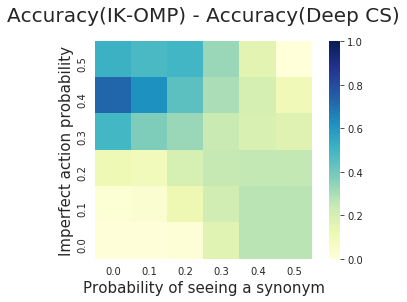

In [46]:
# corr = np.corrcoef(np.random.randn(10, 200))
mask = np.zeros_like(results[0])
ticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
# mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(cs_results[::-1,:] - results[2,::-1,:], mask=mask, vmin=0, vmax=1, square=True,  cmap="YlGnBu", xticklabels=ticks, yticklabels=ticks[::-1])
    ax.set_xlabel('Probability of seeing a synonym', fontsize=15)
    ax.set_ylabel('Imperfect action probability', fontsize=15)
    ax.set_title('Accuracy(IK-OMP) - Accuracy(Deep CS)', fontsize=20, pad=20)
    plt.show()
    
#     ax = sns.heatmap(cs_results[::-1,:], mask=mask, vmin=0, vmax=1, square=True,  cmap="YlGnBu", xticklabels=ticks, yticklabels=ticks[::-1])
#     ax.set_xlabel('Ambiguitiy Probability')
#     ax.set_ylabel('Imperfect Probability')
#     ax.set_title('IK-OMP')
#     plt.show()

In [ ]:
print(results)

results for safe keeping

In [ ]:
# results_reward = {0.3: {0.0: [35, 35], 0.05: [35, 35], 0.1: [35, 35], 0.15: [35, 35], 0.2: [35, 35], 0.25: [35, 35], 0.3: [35, 35], 0.35: [35, 35], 0.4: [10, 0], 0.45: [0, 0], 0.5: [0, 0]}, 0.5: {0.0: [35, 35], 0.05: [35, 35], 0.1: [35, 35], 0.15: [35, 35], 0.2: [35, 35], 0.25: [35, 35], 0.3: [35, 35], 0.35: [10, 0], 0.4: [0, 0], 0.45: [0, 0], 0.5: [0, 0]}, 0.7: {0.0: [35, 35], 0.05: [35, 35], 0.1: [35, 35], 0.15: [35, 35], 0.2: [35, 35], 0.25: [35, 35], 0.3: [10, 0], 0.35: [0, 0], 0.4: [0, 0], 0.45: [0, 0], 0.5: [0, 0]}, 0.9: {0.0: [35, 35], 0.05: [35, 35], 0.1: [35, 35], 0.15: [35, 35], 0.2: [35, 35], 0.25: [10, 10], 0.3: [0, 0], 0.35: [0, 0], 0.4: [0, 0], 0.45: [0, 0], 0.5: [0, 0]}}

In [ ]:
results_reward = {}
probs = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

for threshold in [0.3, 0.5, 0.7, 0.9]:
    results_reward[threshold] = {}
    for prob in probs:
        results_reward[threshold][prob] = []

for subdir in range(5):
    for prob in probs:
        for threshold in [0.3, 0.5, 0.7, 0.9]:
            print(str(subdir) + ' ' + str(prob) + ' ' + str(threshold))
            full_path = path + str(prob) + '/' + str(subdir) + '/20000'
            network.load_state_dict(torch.load(full_path + '/network'))
            results_reward[threshold][prob].append(test_env(False, threshold))

In [ ]:
print(results_reward)

In [ ]:
colors = ['#396ab1', '#da7c30', '#3e9651', '#cc2529', '#94823d', '#535154', '#006400', '#00FF00', '#800000', '#F08080', '#FFFF00', '#000000', '#C0C0C0']
facecolors = ['#7293cb', '#e1974c', '#84ba5b', '#d35e60', '#ccc210', '#808585']

f, axarr = pl.subplots(1, 1, figsize=(6, 3))

idx = 0
for test_name in results_reward:
    avg = [res[0] for res in results_reward[test_name]]
    std = [res[1] for res in results_reward[test_name]]
    pl.plot(snr, avg, label=test_name, color=colors[idx])
    pl.fill_between(snr, np.array(avg) - np.array(std), np.array(avg) + np.array(std), facecolor=facecolors[idx], alpha=0.2, interpolate=True)
    idx += 1

leg = pl.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=3, fontsize=10)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
    
#pl.suptitle('Egg Quest, Minimal Action Set,\n GloVe, Training with K=all', fontsize=20, y=1.1)
pl.xlabel('SnR')
pl.ylabel('Reward')
pl.show()

In [ ]:
print(words)
print(len(words))

In [ ]:
print(dictionary)
print(len(dictionary))

In [ ]:
coherence = 0
for w1 in dictionary:
    for w2 in dictionary:
        if w1 != w2:
            top = np.abs(np.sum(word2vec_model[w1] * word2vec_model[w2]))
            bottom = np.sqrt(np.sum(word2vec_model[w1] * word2vec_model[w1]) * np.sum(word2vec_model[w2] * word2vec_model[w2]))
            couple_coherence = top/bottom
            coherence = max(coherence, couple_coherence)
print(coherence)